C:\Users\lalad\AppData\Local\Temp\ipykernel_28784\2491433351.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection, params=(game_id,))


  event_type                  player_id                    team_id     x  \
0       PASS  6g9x1y7xmjzwhk646v1iyuup5  cyrrlv6l1onld5x247w1q1jlr  50.0   
1       PASS  er6z557ns3jcjhgrsbtmsn6s4  89xivtxk59uzvhdsd6miao6tm  49.7   
2       PASS  cfxzvlgvt9jj17qxq41t9sxcl  cyrrlv6l1onld5x247w1q1jlr  39.1   
3       PASS  2ky2kn7gpjorkyg9zyg68pk6i  cyrrlv6l1onld5x247w1q1jlr  36.3   
4       PASS  a3on8aipuz77wn25jm2r312lm  89xivtxk59uzvhdsd6miao6tm  33.0   

      y                    game_id                    time     outcome  
0  50.0  5pcyhm34h5c948yji4oryevpw  0 days 00:00:00.087000    COMPLETE  
1  50.0  5qa6smqwjobwdm3j0okr0r09g  0 days 00:00:00.025000    COMPLETE  
2  48.0  5pcyhm34h5c948yji4oryevpw  0 days 00:00:01.627000    COMPLETE  
3  36.4  5pcyhm34h5c948yji4oryevpw  0 days 00:00:04.178000  INCOMPLETE  
4  37.4  5qa6smqwjobwdm3j0okr0r09g  0 days 00:00:02.775000    COMPLETE  
         y_0         y_1        y_2         y_3         y_4        y_5  \
0    0.00000    0.000000  232.5

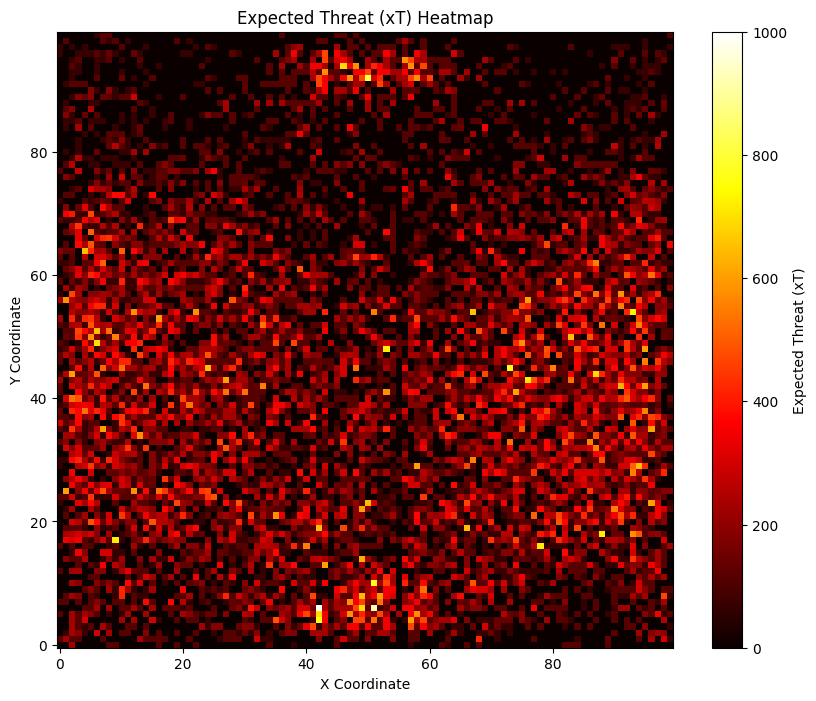

In [1]:
import psycopg2
import dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

def get_connection():
    return psycopg2.connect(
        host=PG_HOST,
        database=PG_DATABASE,
        user=PG_USER,
        password=PG_PASSWORD,
        port=PG_PORT,
        sslmode="require",
    )

def get_event_data(game_id):
    query = """
    SELECT 
    e.name AS event_type,
    me.player_id, 
    me.team_id, 
    me.x, 
    me.y, 
    me.match_id AS game_id, 
    me.timestamp AS time, 
    me.result AS outcome
    FROM matchevents me
    JOIN eventtypes e ON me.eventtype_id = e.eventtype_id
    """
    connection = get_connection()
    df = pd.read_sql(query, connection, params=(game_id,)) 
    connection.close()
    return df

def convert_to_spadl(df):
    spadl_data = []
    for _, row in df.iterrows():
        action = {
            'player_id': row['player_id'],
            'event_type': row['event_type'],
            'x': row['x'],
            'y': row['y'],
            'outcome': row['outcome'],
            'time': row['time'],
            'team_id': row['team_id'],
            'game_id': row['game_id']
        }
        spadl_data.append(action)
    spadl_df = pd.DataFrame(spadl_data)
    return spadl_df

def calculate_xt(df):
    pitch_length = 100
    pitch_width = 100
    
    grid = np.zeros((pitch_length, pitch_width))

    for _, row in df.iterrows():
        start_x = int(row['x'])  
        start_y = int(row['y'])  
        
        if pd.isna(row['outcome']) or row['outcome'] in ['INCOMPLETE', 'None']:
            continue  
        

        if row['event_type'] == 'PASS':
            try:
                if isinstance(row['outcome'], (list, tuple)) and len(row['outcome']) == 2:
                    end_x, end_y = int(row['outcome'][0]), int(row['outcome'][1])
                    xT = 0.05 * (end_x - start_x) + 0.05 * (end_y - start_y)
                    grid[start_x, start_y] += xT
            except (ValueError, TypeError):
                continue
        
        elif row['event_type'] == 'SHOT':
            try:
                if isinstance(row['outcome'], (list, tuple)) and len(row['outcome']) == 2:
                    end_x, end_y = int(row['outcome'][0]), int(row['outcome'][1])
                    xT = 0.2 * (100 - end_x) + 0.1 * (end_y - 50)
                    grid[start_x, start_y] += xT
            except (ValueError, TypeError):
                continue
        
        elif row['event_type'] == 'DUEL' and row['outcome'] == 'WON':
            xT = 0.05
            grid[start_x, start_y] += xT


        elif row['event_type'] == 'TAKE_ON' and row['outcome'] == 'SUCCESS':
            xT = 0.05  
            grid[start_x, start_y] += xT
        

        elif row['event_type'] == 'RECOVERY':
            xT = 0.02  
            grid[start_x, start_y] += xT

        elif row['event_type'] == 'INTERCEPTION':
            xT = 0.03
            grid[start_x, start_y] += xT
        

        elif row['event_type'] == 'GENERIC:ball touch':
            xT = 0.01  
            grid[start_x, start_y] += xT
        
        elif row['event_type'] == 'GENERIC:dispossessed':
            xT = 0.01 
            grid[start_x, start_y] += xT

   
    max_value = np.max(grid)
    if max_value > 0:
        grid = (grid / max_value) * 1000  

    xt_df = pd.DataFrame(grid, columns=[f"y_{i}" for i in range(pitch_width)])
    return xt_df

def plot_xt_heatmap(xt_df):
    plt.figure(figsize=(10, 8))
    plt.imshow(xt_df.values, cmap='hot', interpolation='nearest', origin='lower')
    plt.colorbar(label="Expected Threat (xT)")
    plt.title("Expected Threat (xT) Heatmap")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

def main():
    game_id = "5pcyhm34h5c948yji4oryevpw"  
    event_data = get_event_data(game_id)
    

    if event_data.empty:
        print(f"No event data found for game_id: {game_id}")
    else:
        print(event_data.head())  
    
    spadl_data = convert_to_spadl(event_data)
    
    xt_values = calculate_xt(spadl_data)

    print(xt_values.head())

    plot_xt_heatmap(xt_values)

if __name__ == '__main__':
    main()